In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
folder='./UCR_TS_Archive_2015'
file_list=next(os.walk(folder))[1]

In [3]:
def ucr_data_loader(filename,folder='./UCR_TS_Archive_2015'):
    f=folder+'/'+filename
    train_file=f+'/'+filename+'_TRAIN'
    test_file=f+'/'+filename+'_TEST'
    df_train=pd.read_csv(train_file,header=None)
    df_test=pd.read_csv(test_file,header=None)

    y_train=df_train[0]
    X_train=df_train.drop(0,axis=1)
    y_test=df_test[0]
    X_test=df_test.drop(0,axis=1)

    return X_train,y_train,X_test,y_test

In [95]:
file='Adiac'
X_train,y_train,X_test,y_test=ucr_data_loader(file)
X_train=(X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test=(X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)
print(X_train.shape)
print(X_test.shape)

(390, 176)
(391, 176)


In [7]:
from keras.layers.core import Activation,Dense,Dropout,Flatten
from keras.layers import Input,Conv1D,MaxPooling1D,BatchNormalization
from keras.models import Model

In [116]:
x

<tf.Tensor 'raw_data_31:0' shape=(?, 176, 1) dtype=float32>

In [121]:
input_shape=(X_train.shape[1],1)
n_class=len(np.unique(y_train))
x=Input(input_shape,name='raw_data')
bn1=x
conv1=Conv1D(nb_filter=8,filter_length=8)(bn1)
act1=Activation('relu')(conv1)
maxpool1=MaxPooling1D()(act1)
dr1=Dropout(dr)(maxpool1)
bn1=BatchNormalization()(dr1)
fl=Flatten()(bn1)
y=Dense(n_class,activation='softmax')(fl)

model=Model(input=x,output=y)
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.sparse_categorical_crossentropy])


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=8)`
/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ra..., outputs=Tensor("de...)`


In [134]:
class ConvNetTS:
    def __init__(self, X_train,y_train,K=32,l=4,n_layers=3,dr=0.2):
        input_shape=(X_train.shape[1],1)
        n_class=len(np.unique(y_train))
        x=Input(input_shape,name='raw_data')
        bn1=x
        for i in range(n_layers):
            conv1=Conv1D(nb_filter=K,filter_length=l)(bn1)
            act1=Activation('relu')(conv1)
            maxpool1=MaxPooling1D()(act1)
            dr1=Dropout(dr)(maxpool1)
            bn1=BatchNormalization()(dr1)

        fl=Flatten()(bn1)
        y=Dense(n_class,activation='softmax')(fl)
        self.model=Model(input=x,output=y)
        self.model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',
                           metrics=['sparse_categorical_crossentropy'])

    def fit(self,X_train,Y_train,iterations=100,verbose=2,plot_loss=False,X_test=[],y_test=[]):
        x_tr=X_train.values.reshape(X_train.shape[:2]+(1,))
        y_tr=y_train-min(y_train)
        self.offset=min(y_train)
        if len(X_test)==0:
            history=self.model.fit(x_tr,y_tr,nb_epoch=iterations,verbose=verbose,batch_size=1+int(0.05*X_train.shape[0]))
        else:
            x_ts=X_test.values.reshape(X_test.shape[:2]+(1,))
            y_ts=y_test-self.offset
            history=self.model.fit(x_tr,y_tr,nb_epoch=iterations,verbose=verbose,
                                  validation_data=[x_ts,y_ts],batch_size=int(0.05*X_train.shape[0])+1)
        
        if plot_loss==True:
            if len(X_test)==0:
                plt.figure(figsize=(24,6))
                plt.plot(history.history['loss'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train'], loc='upper left')
                plt.show()
            else:
                plt.figure(figsize=(24,6))
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()

                

    def predict(self,X_test):
        x_ts=X_test.values.reshape(X_test.shape[:2]+(1,))
        y_pred=self.model.predict(x_ts)
        return y_pred.argmax(axis=1)+self.offset
    
    def compute_accuracy(self,X_test,y_test):
        x_test=X_test.values.reshape(X_test.shape[:2]+(1,))
        y_pred=self.model.predict(x_test).argmax(axis=1)+self.offset
        return np.sum(y_pred==y_test)/len(y_pred)

In [135]:
for f in np.sort(file_list):
    print(f)

50words
Adiac
ArrowHead
Beef
BeetleFly
BirdChicken
CBF
Car
ChlorineConcentration
CinC_ECG_torso
Coffee
Computers
Cricket_X
Cricket_Y
Cricket_Z
DiatomSizeReduction
DistalPhalanxOutlineAgeGroup
DistalPhalanxOutlineCorrect
DistalPhalanxTW
ECG200
ECG5000
ECGFiveDays
Earthquakes
ElectricDevices
FISH
FaceAll
FaceFour
FacesUCR
FordA
FordB
Gun_Point
Ham
HandOutlines
Haptics
Herring
InlineSkate
InsectWingbeatSound
ItalyPowerDemand
LargeKitchenAppliances
Lighting2
Lighting7
MALLAT
Meat
MedicalImages
MiddlePhalanxOutlineAgeGroup
MiddlePhalanxOutlineCorrect
MiddlePhalanxTW
MoteStrain
NonInvasiveFatalECG_Thorax1
NonInvasiveFatalECG_Thorax2
OSULeaf
OliveOil
PhalangesOutlinesCorrect
Phoneme
Plane
ProximalPhalanxOutlineAgeGroup
ProximalPhalanxOutlineCorrect
ProximalPhalanxTW
RefrigerationDevices
ScreenType
ShapeletSim
ShapesAll
SmallKitchenAppliances
SonyAIBORobotSurface
SonyAIBORobotSurfaceII
StarLightCurves
Strawberry
SwedishLeaf
Symbols
ToeSegmentation1
ToeSegmentation2
Trace
TwoLeadECG
Two_Pattern

In [136]:
flist=['Adiac','Beef','BeetleFly','BirdChicken','ChlorineConcentration',
       'Coffee','DiatomSizeReduction','ECGFiveDays','FaceFour',
       'Gun_Point','ItalyPowerDemand','Lighting7',
       'MedicalImages','MoteStrain','SonyAIBORobotSurface',
       'Symbols','synthetic_control','Trace','TwoLeadECG']

In [18]:
print(file)
X_train,y_train,X_test,y_test=ucr_data_loader(file)
print('Train Shape: ', X_train.shape)
print('Test Shape: ', X_test.shape)
print('Number of classes: ', len(np.unique(y_train)))

Adiac
Train Shape:  (390, 176)
Test Shape:  (391, 176)
Number of classes:  37


In [145]:
class LearningTS:
    def __init__(self, X_train,y_train,K=32,l=4,n_layers=3,dr=0.2):
        input_shape=(X_train.shape[1],1)
        n_class=len(np.unique(y_train))
        x=Input(input_shape,name='raw_data')
        bn1=x
        conv1=SlidingDist(filters=128,kernel_size=[20],input_shape=input_shape,data_format='channels_last')(bn1)
        fl=Flatten()(bn1)
        y=Dense(n_class,activation='softmax')(fl)
        self.model=Model(input=x,output=y)
        self.model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy')

    def fit(self,X_train,Y_train,iterations=100,verbose=2,plot_loss=False,X_test=[],y_test=[]):
        x_tr=X_train.values.reshape(X_train.shape[:2]+(1,))
        y_tr=y_train-min(y_train)
        self.offset=min(y_train)
        if len(X_test)==0:
            history=self.model.fit(x_tr,y_tr,nb_epoch=iterations,verbose=verbose,batch_size=1+int(0.05*X_train.shape[0]))
        else:
            x_ts=X_test.values.reshape(X_test.shape[:2]+(1,))
            y_ts=y_test-self.offset
            history=self.model.fit(x_tr,y_tr,nb_epoch=iterations,verbose=verbose,
                                  validation_data=[x_ts,y_ts],batch_size=int(0.05*X_train.shape[0])+1)
        
        if plot_loss==True:
            if len(X_test)==0:
                plt.figure(figsize=(24,6))
                plt.plot(history.history['loss'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train'], loc='upper left')
                plt.show()
            else:
                plt.figure(figsize=(24,6))
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()

                

    def predict(self,X_test):
        x_ts=X_test.values.reshape(X_test.shape[:2]+(1,))
        y_pred=self.model.predict(x_ts)
        return y_pred.argmax(axis=1)+self.offset
    
    def compute_accuracy(self,X_test,y_test):
        x_test=X_test.values.reshape(X_test.shape[:2]+(1,))
        y_pred=self.model.predict(x_test).argmax(axis=1)+self.offset
        return np.sum(y_pred==y_test)/len(y_pred)

In [146]:
from keras import backend as back
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.initializers import RandomUniform
import numpy as np
import tensorflow as tf

class SlidingDist(Layer):
    def __init__(self, filters, kernel_size, input_shape, data_format, kernel_initializer='random_uniform',
                output_dim=None, **kwargs):
        self.filters=filters
        self.kernel_size=kernel_size
        self.kernel_initializer=kernel_initializer
        self.data_format=conv_utils.normalize_data_format(data_format)
        self.output_dim=output_dim
        super(SlidingDist,self).__init__(**kwargs)
        
    def build(self,input_shape):
        if self.data_format=='channels_first':
            channel_axis=1
        else:
            channel_axis=-1
            
        input_dim=input_shape[channel_axis]
        
        kernel_shape=(self.kernel_size[0], input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                     initializer=keras.initializers.RandomUniform(),
                                     trainable=True,
                                     name='kernel')
        super(SlidingDist,self).build(input_shape)
        
    def call(self,x):
        z=back.conv1d(x,self.kernel,data_format='channels_last')
        x2=back.square(x)
        kernel1=tf.constant(np.ones(self.kernel_size[0]).astype(np.float32))
        x2=back.conv1d(x2,tf.reshape(kernel1,(self.kernel_size[0],1,1)),data_format='channels_last')
        k2=back.dot(tf.reshape(self.kernel,[1,-1]),tf.reshape(self.kernel,[-1,1]))
        return back.sqrt(x2+k2-2*z)
    
    def compute_output_shape(self,input_shape):
        print(input_shape)
        if self.data_format=='channels_last':
            space=input_shape[1:-1]
            new_space=[]
            for i in range(len(space)):
                new_dim=space[i]-self.kernel_size[i]+1
                new_space.append(new_dim)
            return (input_shape[0],)+tuple(new_space)+(self.filters,)
        if self.data_format=='channels_first':
            space=input_shape[2:]
            new_space=[]
            for i in range(len(space)):
                new_dim=conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding='same',
                stride=1,
                dilation=1)
                new_space.append(new_dim)
            return (input_shape[0],self.filters)+tuple(new_space)

In [148]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

class BoFClassifier:
    def __init__(self, clf='xgb'):
        if clf=='xgb':
            self.model=GradientBoostingClassifier()
        elif clf=='svc':
            self.model=SVC()
    
    def feat_extraction(self,X):
        h=[]
        h.append(np.mean(X,axis=1)) #Mean
        h.append(np.std(X,axis=1)) #StDev
        h.append(np.min(X,axis=1)) #Min
        h.append(np.max(X,axis=1)) #Max
        h.append(np.sum(np.abs(X[1:]-X[:-1]),axis=1)) #SumOfAbsChanges
        h.append(np.sum(X**2,axis=1)) #SumOfSquares
        h=(h-np.mean(h,axis=0))/np.std(h,axis=0)
        return np.array(h).T

    def fit(self,X_train,y_train):
        x_tr=self.feat_extraction(X_train)
        self.model.fit(x_tr,y_train)
                
    def predict(self,X_test):
        x_ts=self.feat_extraction(X_test)
        y_pred=self.model.predict(x_ts)
        return y_pred
    
    def compute_accuracy(self,X_test,y_test):
        x_ts=self.feat_extraction(X_test)
        y_pred=self.model.predict(x_ts)
        return np.sum(y_test==y_pred)/len(y_test)

Adiac
(None, 176, 1)


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ra..., outputs=Tensor("de...)`
/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


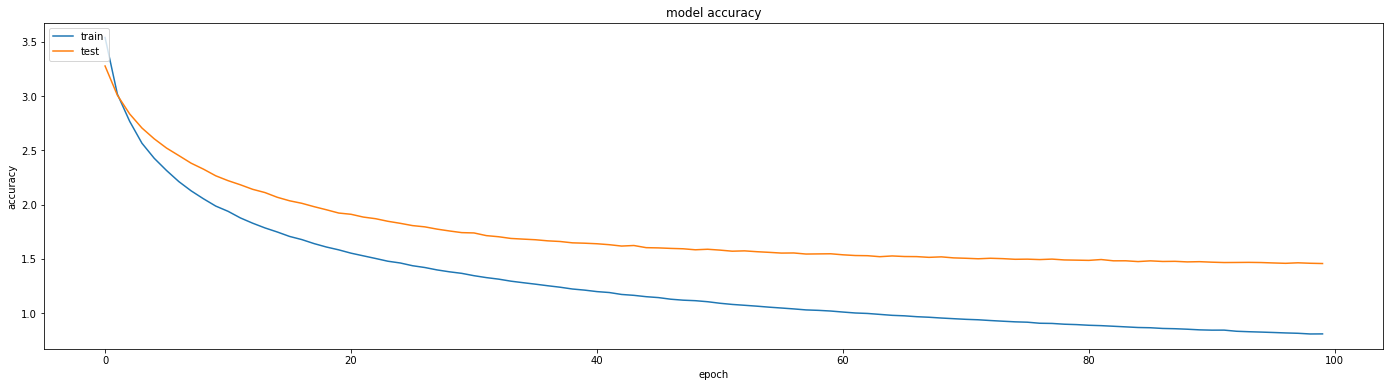

0.685421994885


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=17)`
/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ra..., outputs=Tensor("de...)`
/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


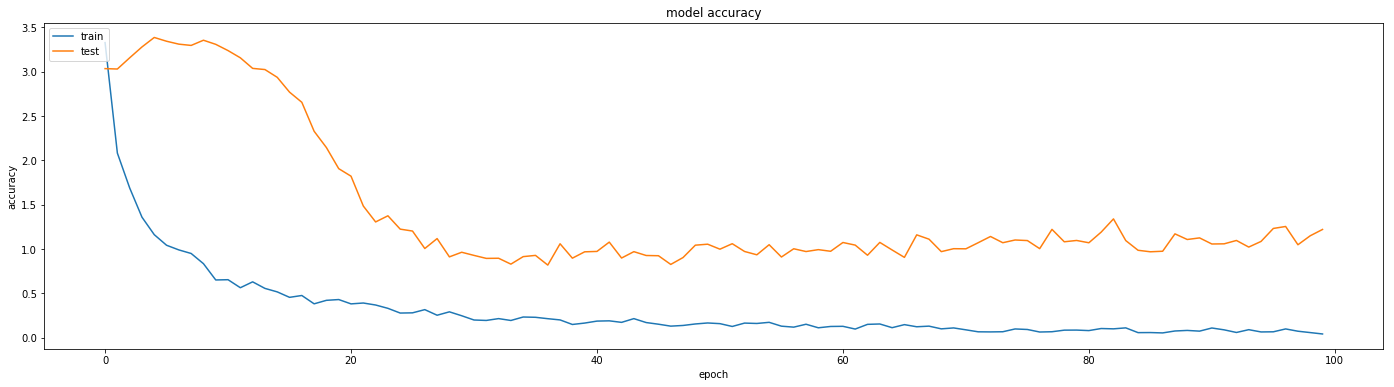

0.72378516624
0.20716112532
Beef
(None, 470, 1)


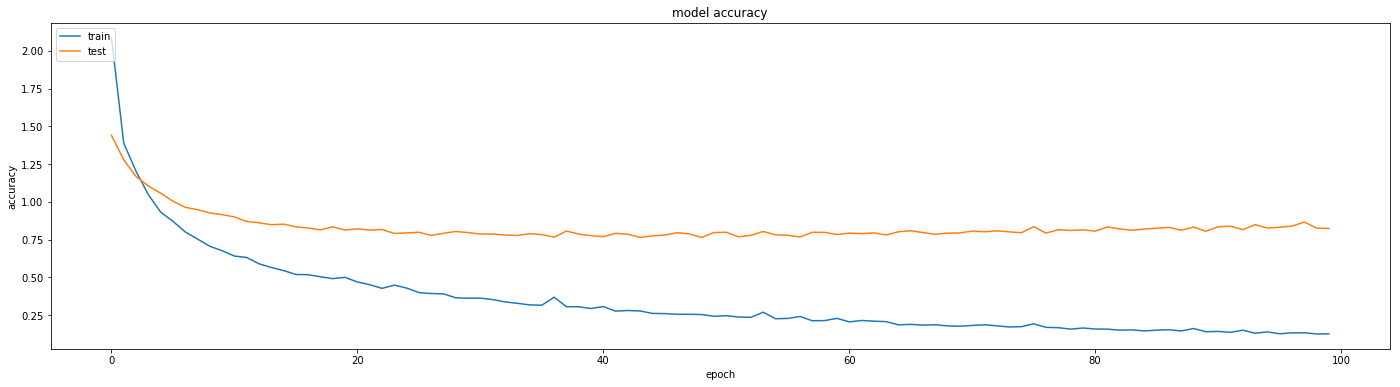

0.866666666667


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=47)`


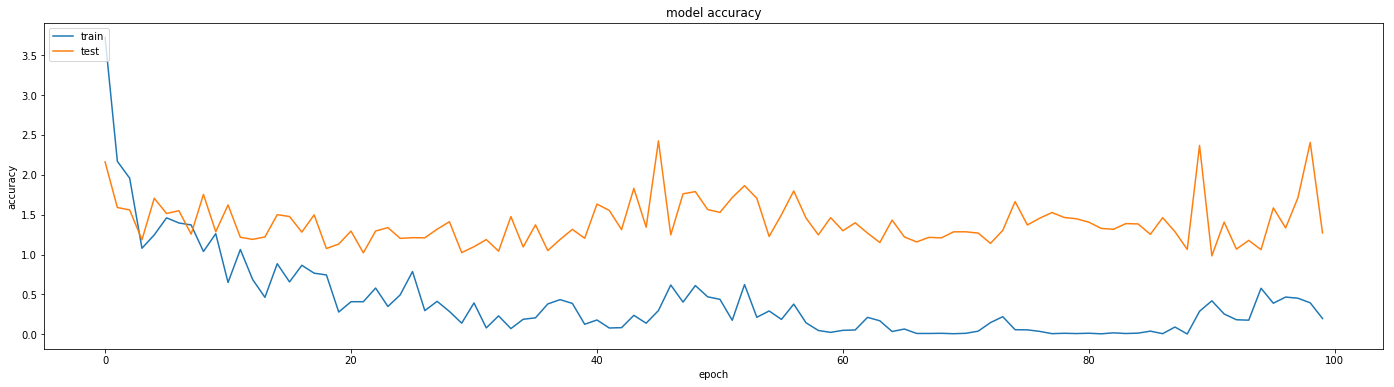

0.866666666667
0.433333333333
BeetleFly
(None, 512, 1)


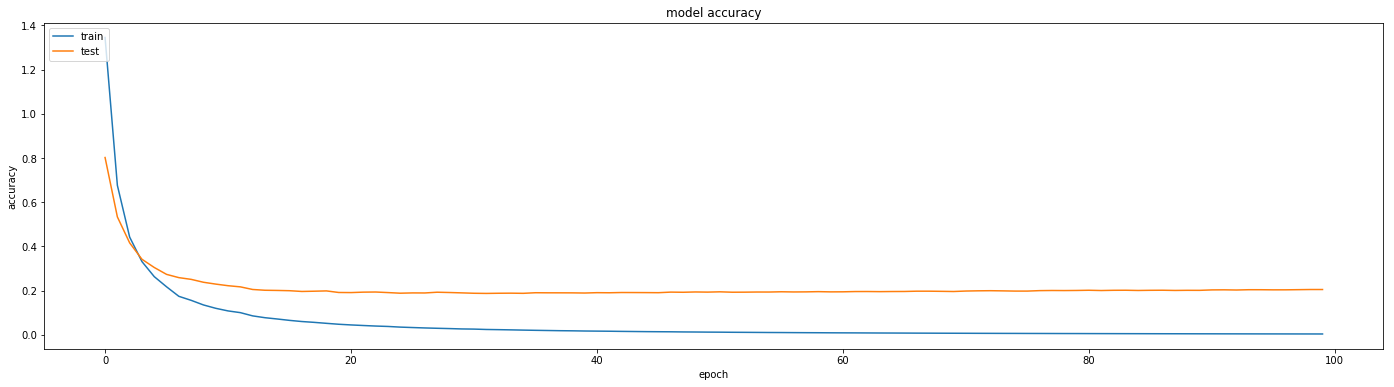

0.9


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=51)`


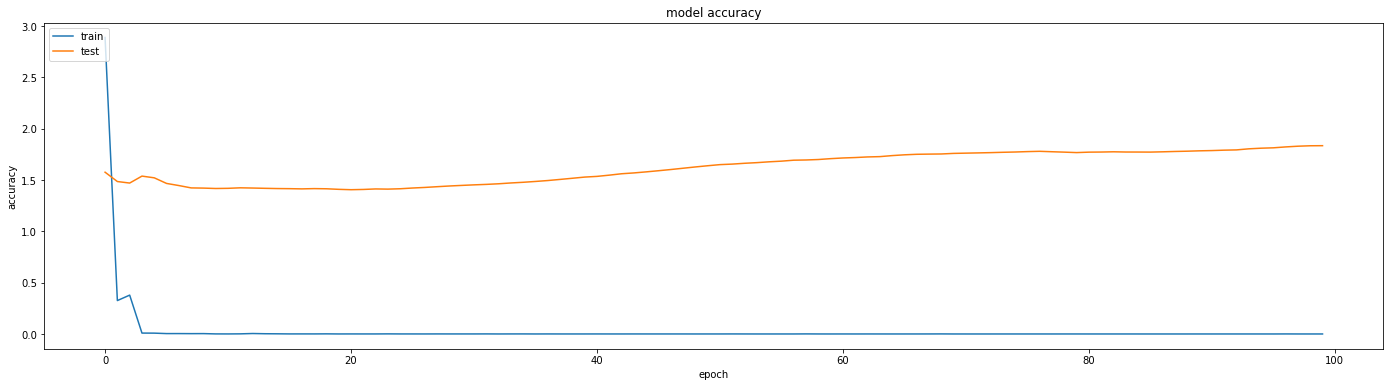

0.5
0.6
BirdChicken
(None, 512, 1)


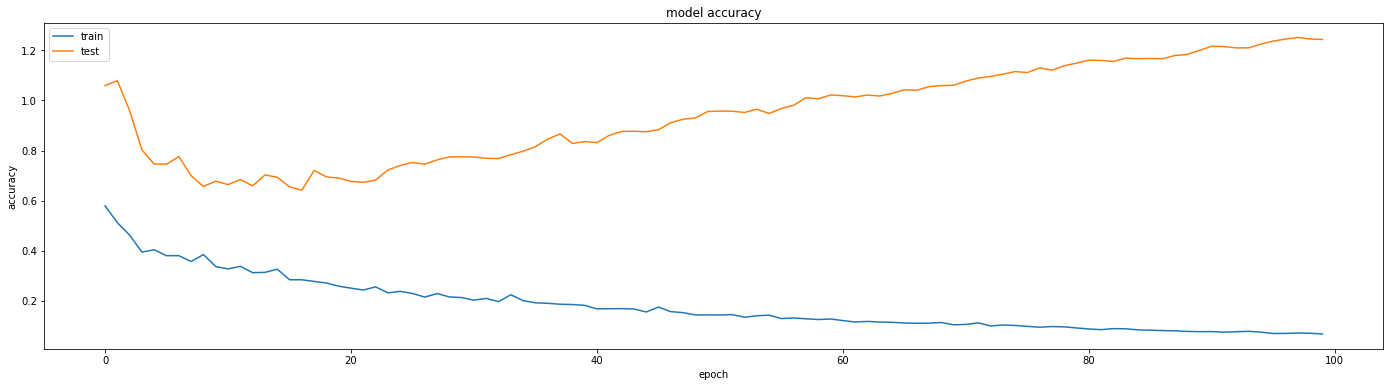

0.7


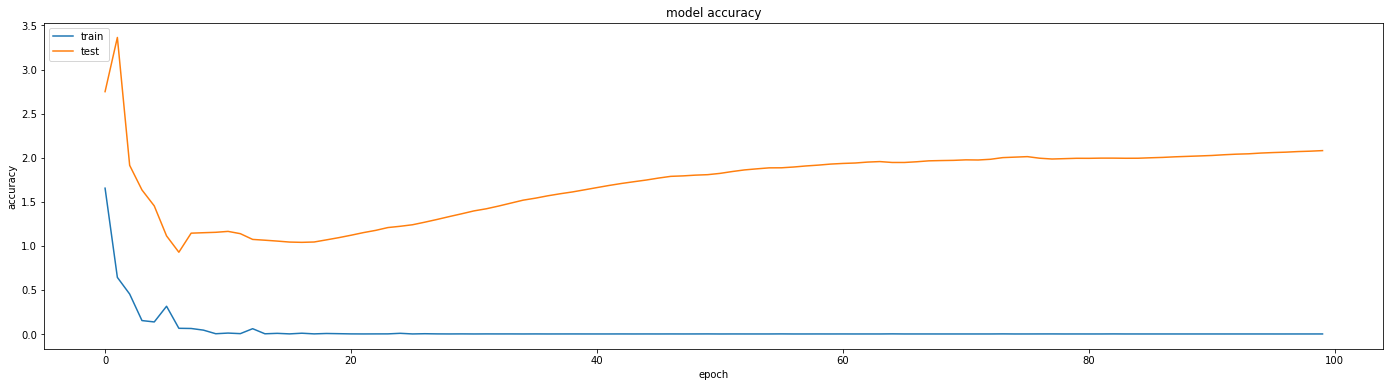

0.65
0.55
ChlorineConcentration
(None, 166, 1)


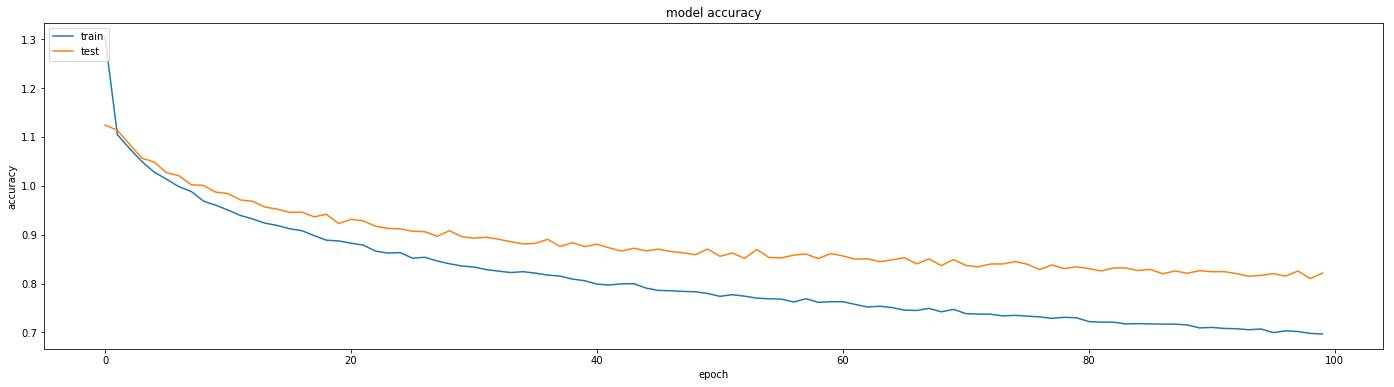

0.594270833333


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=16)`


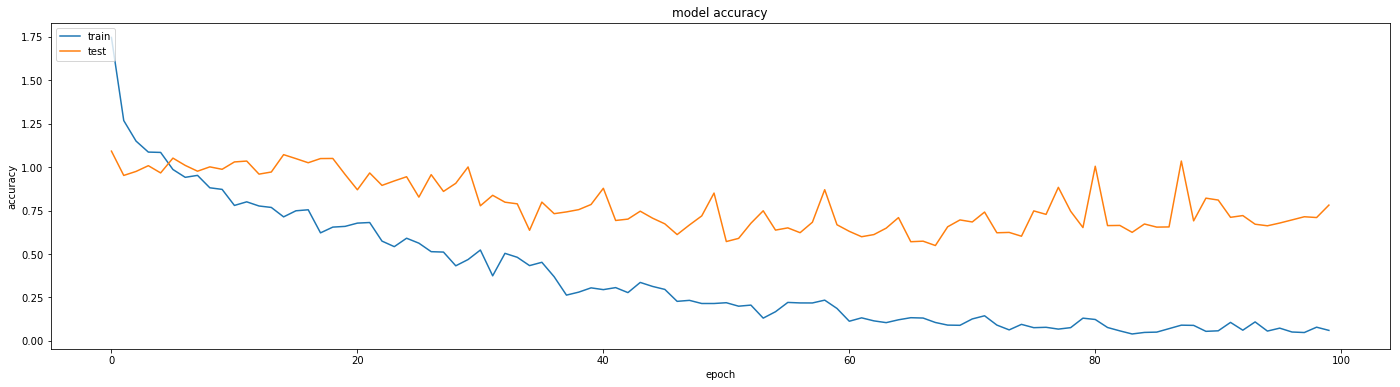

0.834114583333
0.509375
Coffee
(None, 286, 1)


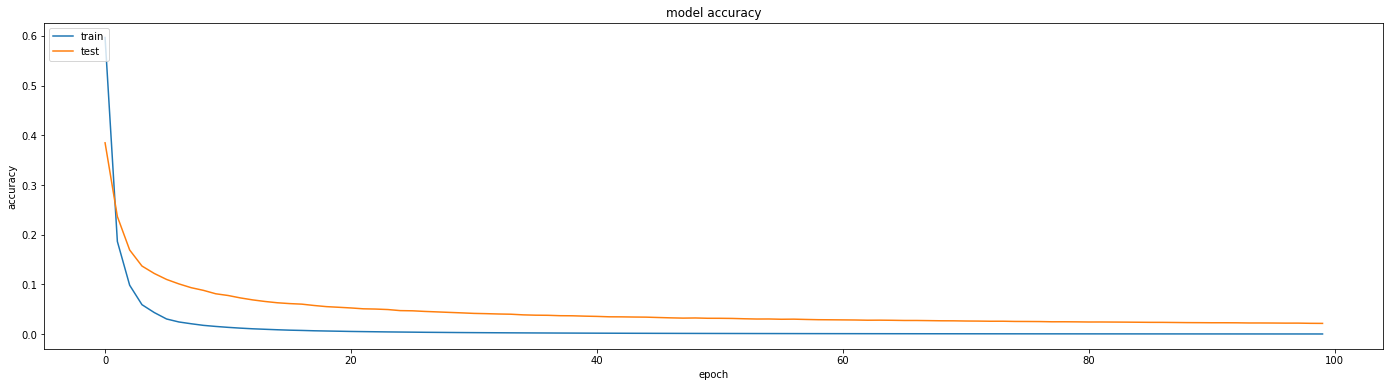

1.0


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=28)`


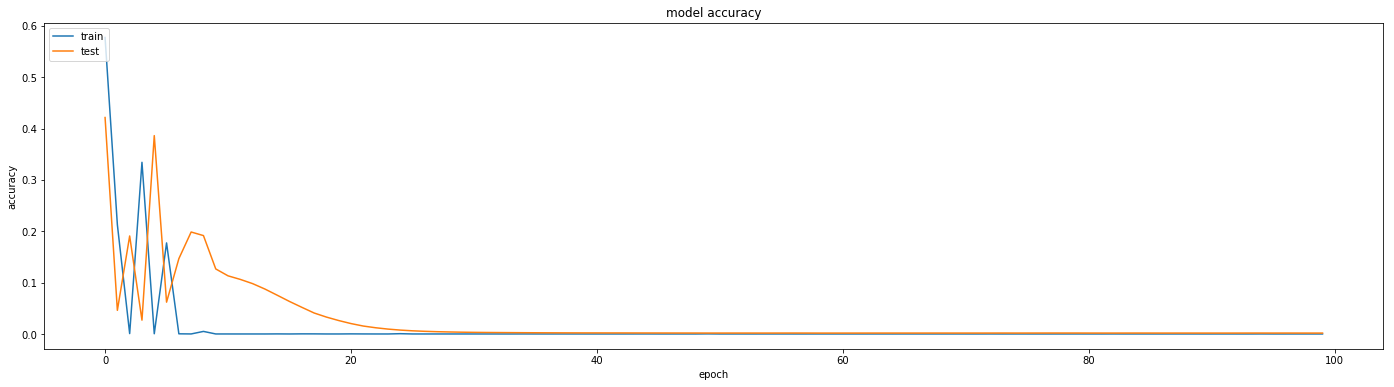

1.0
0.535714285714
DiatomSizeReduction
(None, 345, 1)


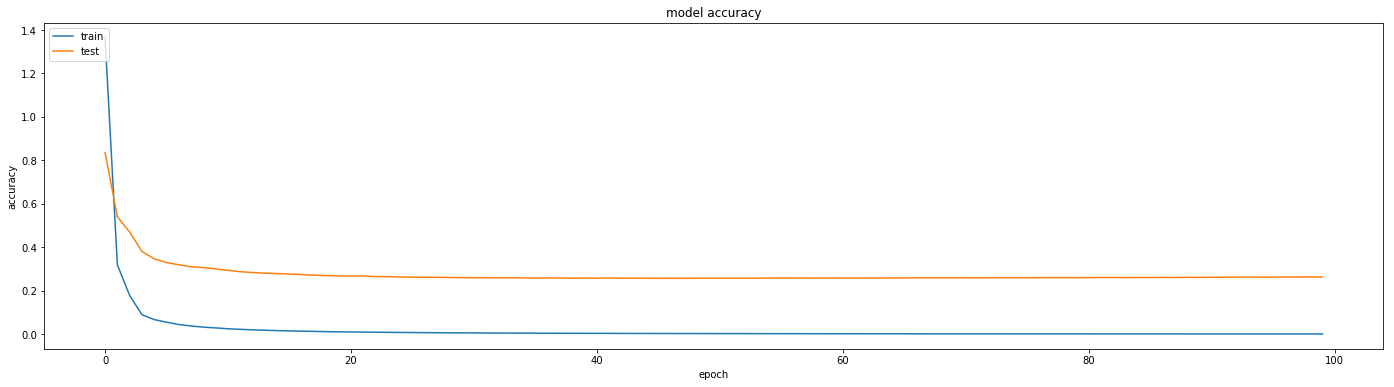

0.937908496732


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=34)`


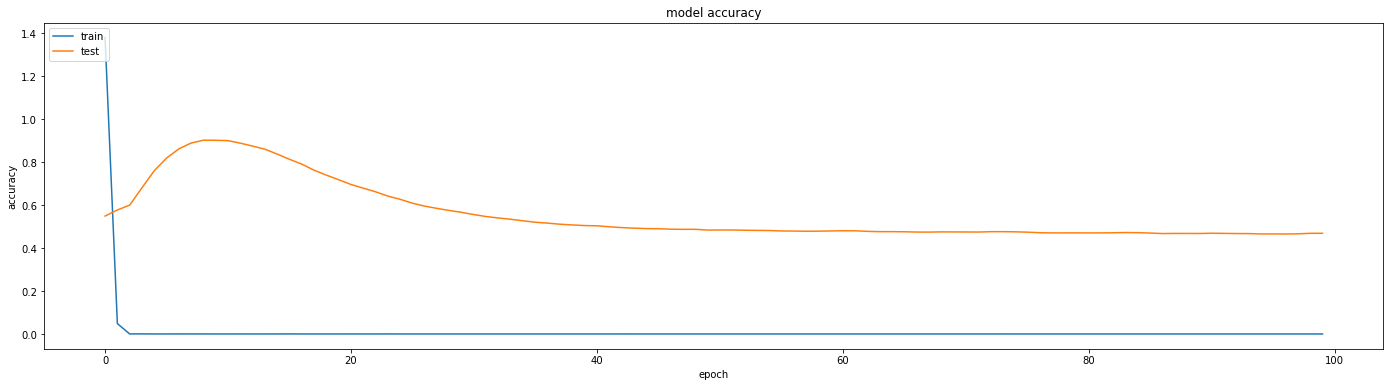

0.866013071895
0.454248366013
ECGFiveDays
(None, 136, 1)


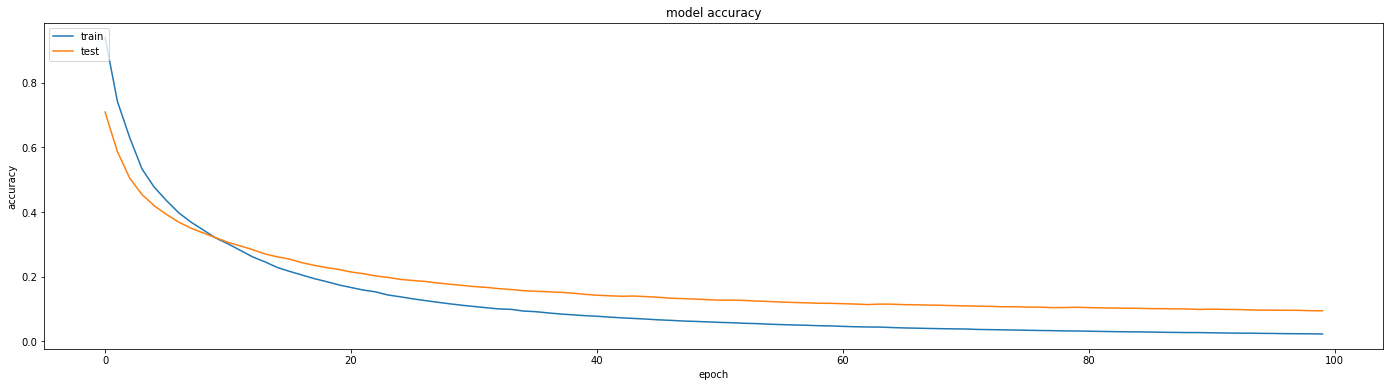

0.966318234611


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=13)`


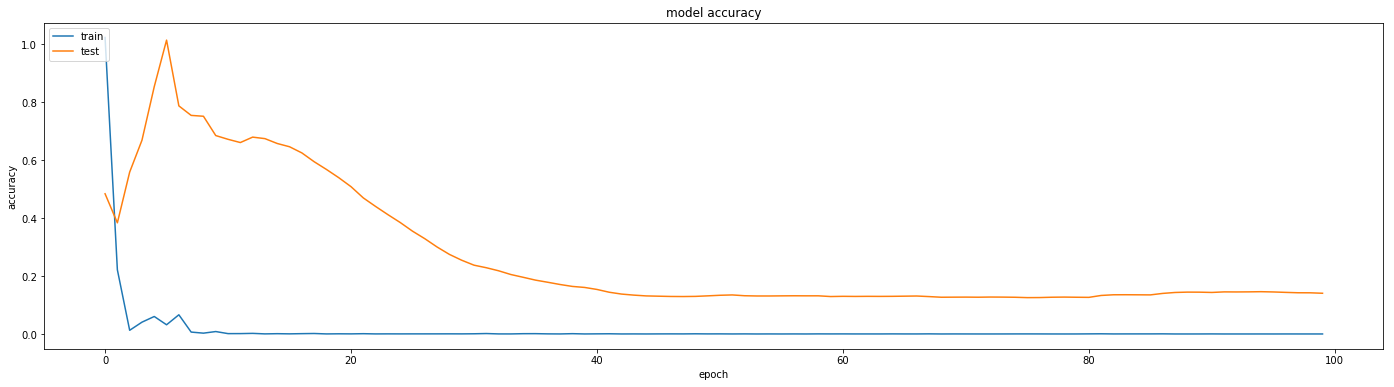

0.959349593496
0.622531939605
FaceFour
(None, 350, 1)


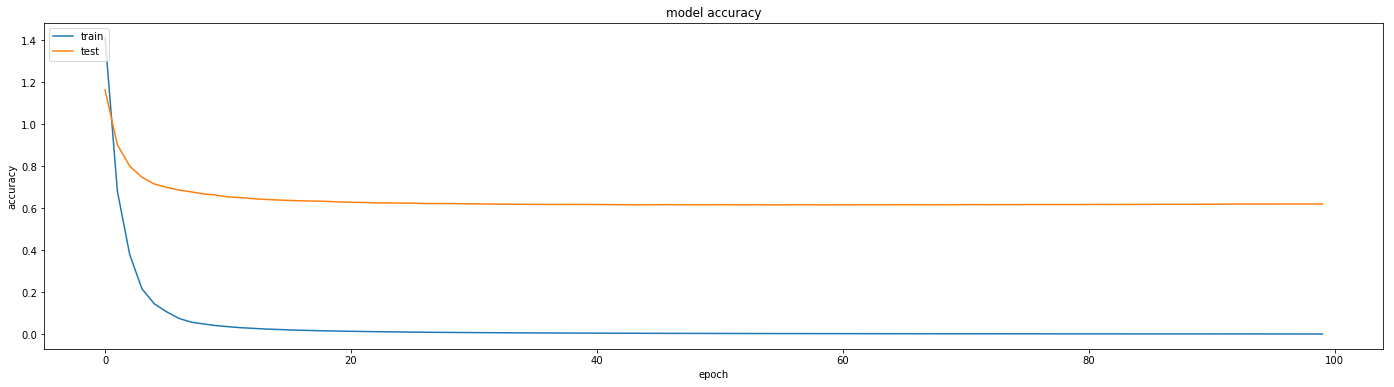

0.840909090909


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=35)`


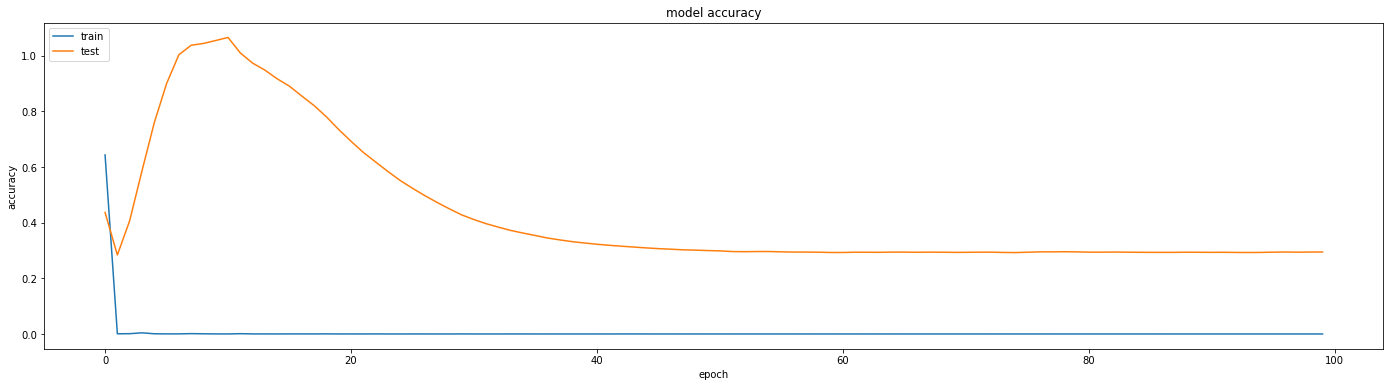

0.943181818182
0.295454545455
Gun_Point
(None, 150, 1)


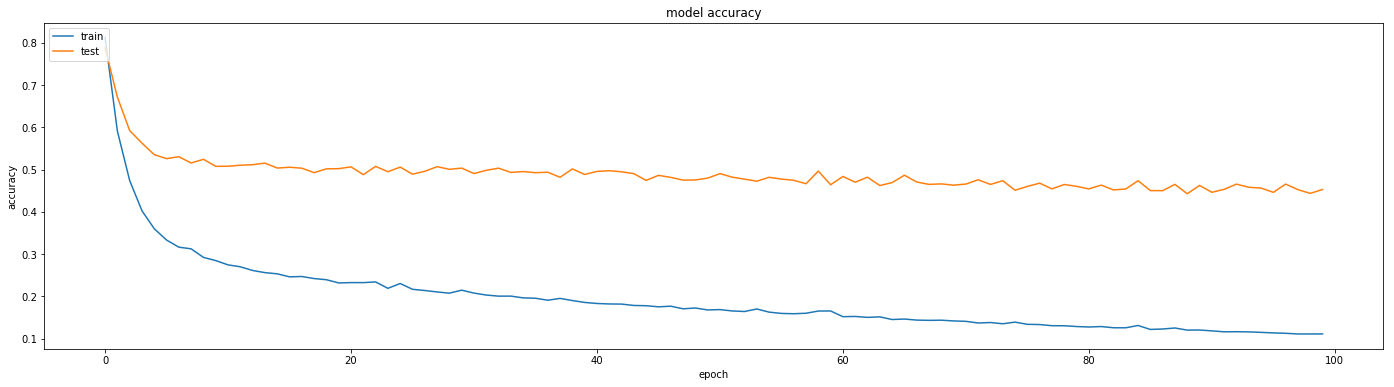

0.8


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=15)`


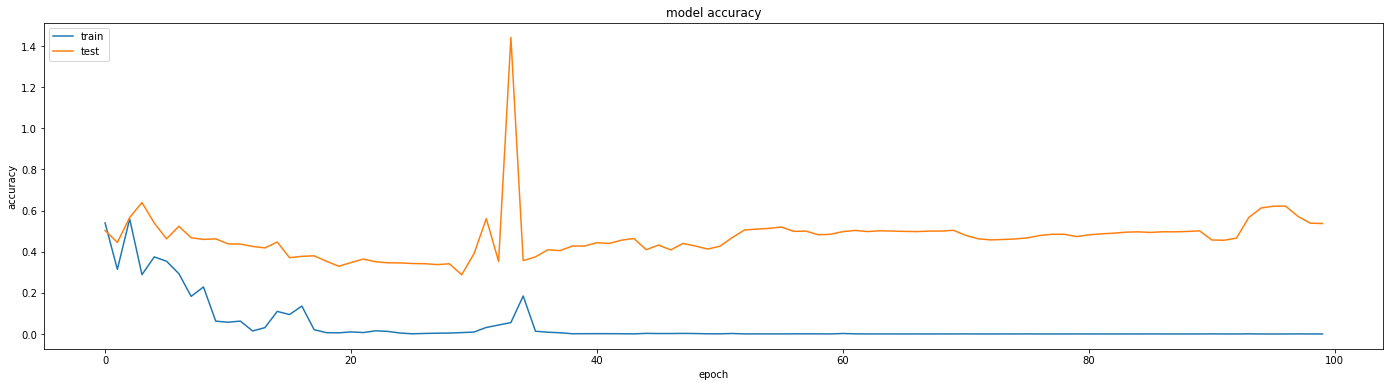

0.9
0.746666666667
ItalyPowerDemand
(None, 24, 1)


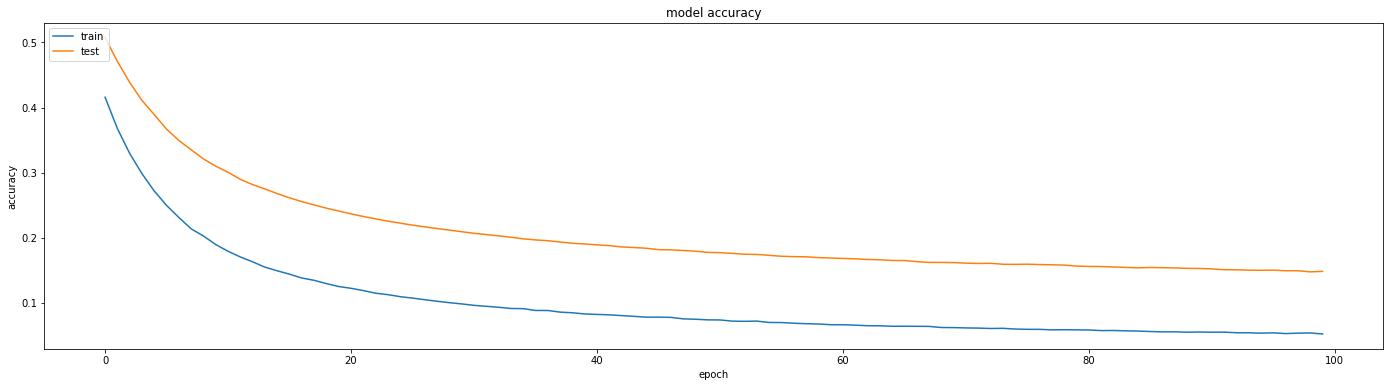

0.941690962099


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=2)`


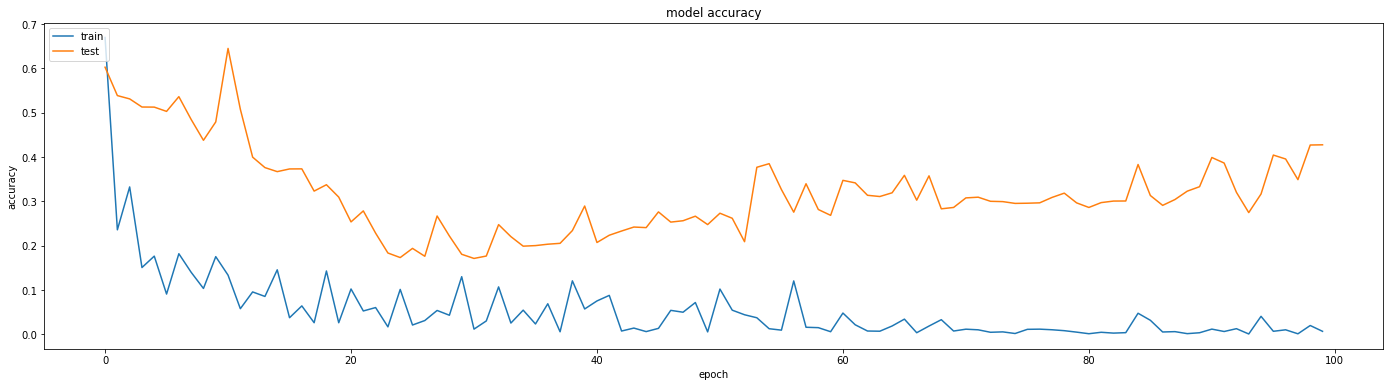

0.919339164237
0.786200194363
Lighting7
(None, 319, 1)


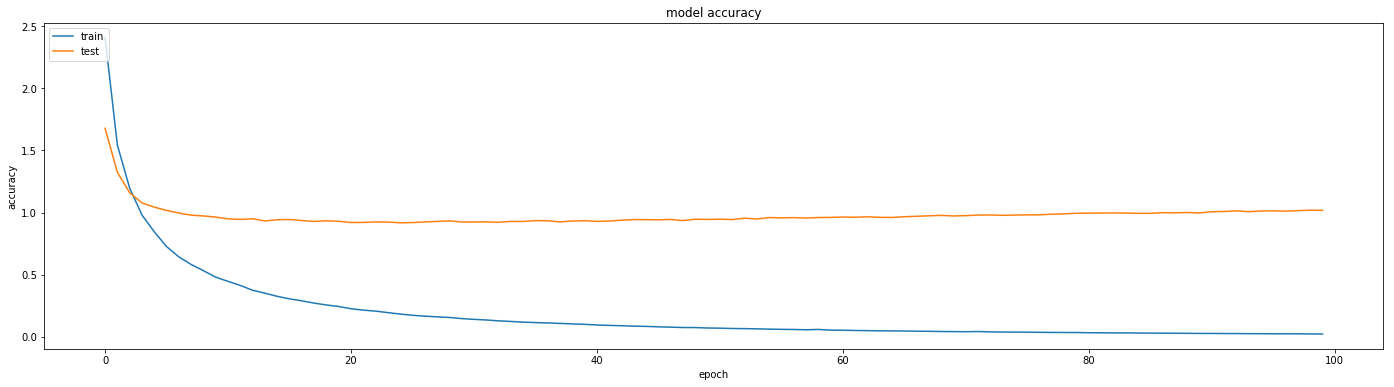

0.657534246575


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=31)`


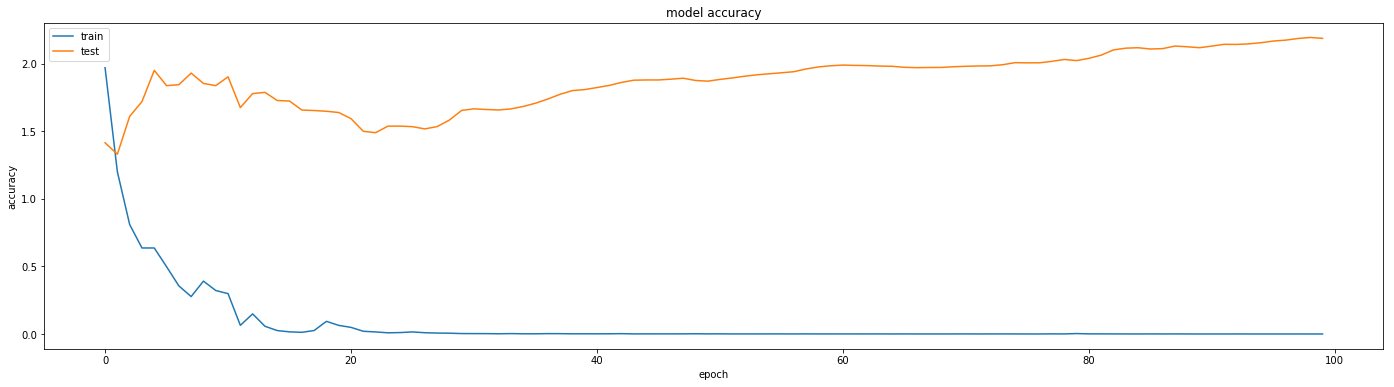

0.547945205479
0.452054794521
MedicalImages
(None, 99, 1)


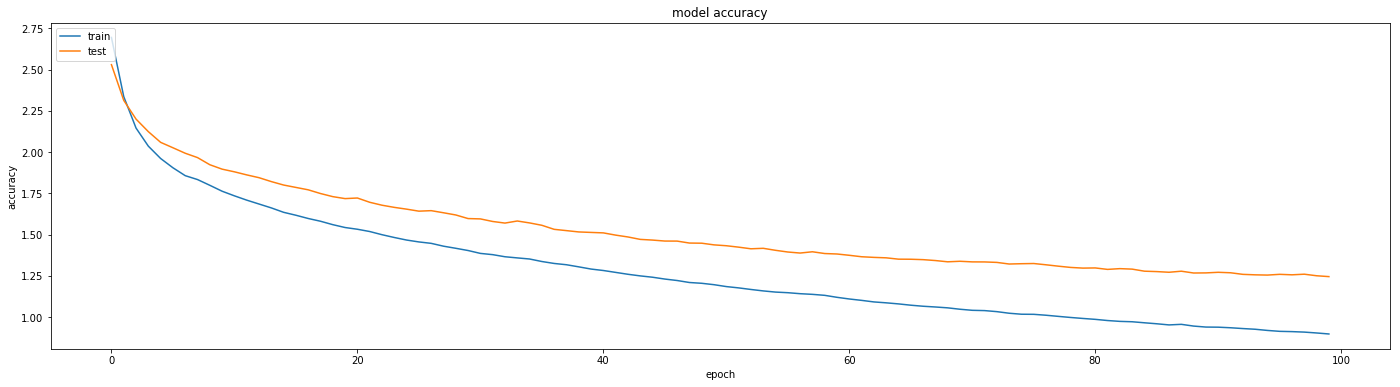

0.571052631579


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=9)`


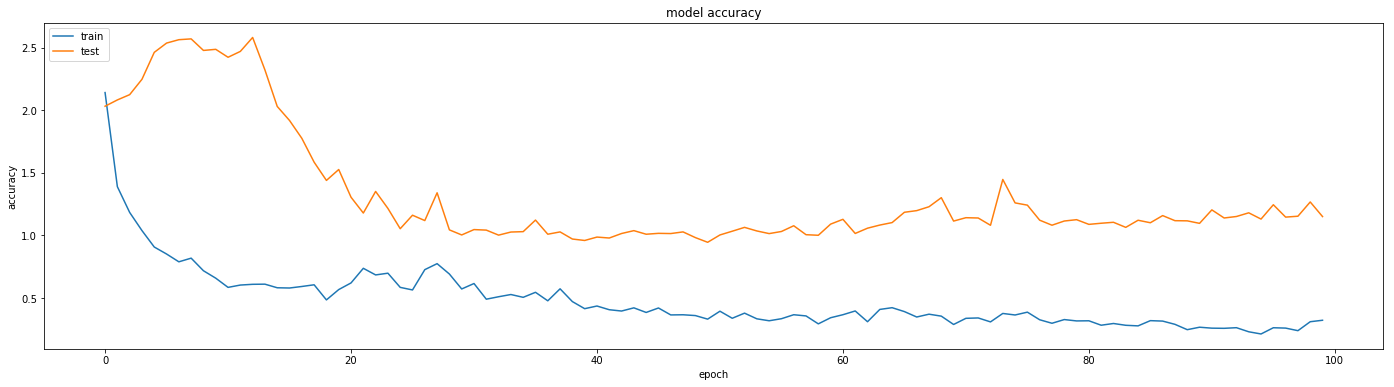

0.668421052632
0.498684210526
MoteStrain
(None, 84, 1)


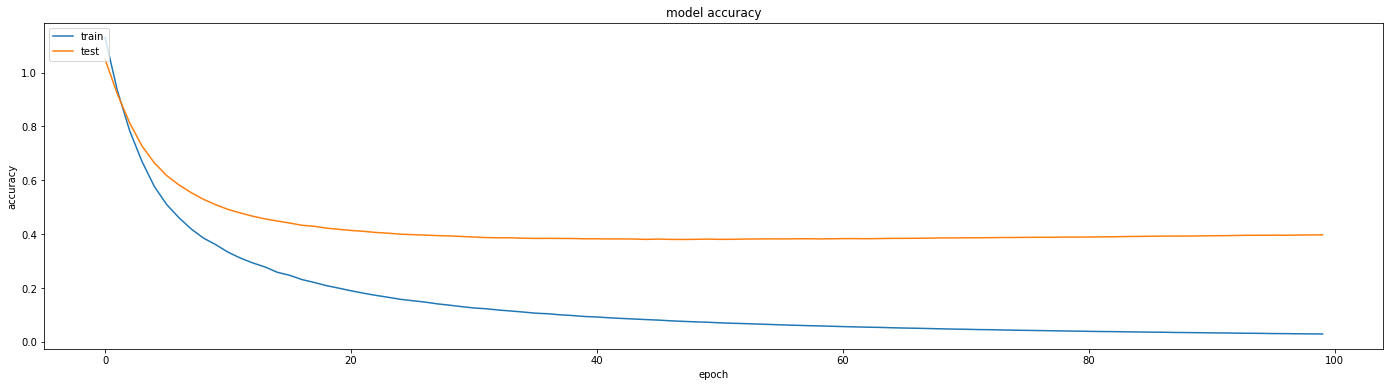

0.859424920128


/home/guillaume/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=8)`


KeyboardInterrupt: 

In [154]:
d={}
list_learningTS=[]
list_ConvNet=[]
list_BoF=[]
for file in flist:
    print(file)
    
    X_train,y_train,X_test,y_test=ucr_data_loader(file)
    X_train=(X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    X_test=(X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

    mod=LearningTS(X_train,y_train,K=128,l=int(0.1*X_train.shape[1]))
    mod.fit(X_train,y_train,iterations=100,plot_loss=True,verbose=0,
           X_test=X_test,y_test=y_test)
    acc=mod.compute_accuracy(X_test,y_test)
    print(acc)
    list_learningTS.append(acc)

    mod=ConvNetTS(X_train,y_train,K=128,l=int(0.1*X_train.shape[1]))
    mod.fit(X_train,y_train,iterations=100,plot_loss=True,verbose=0,
           X_test=X_test,y_test=y_test)
    acc=mod.compute_accuracy(X_test,y_test)
    print(acc)
    list_ConvNet.append(acc)
    
    mod=BoFClassifier()
    mod.fit(X_train,y_train)
    acc=mod.compute_accuracy(X_test,y_test)
    print(acc)
    list_BoF.append(acc)
    


In [35]:
model=BoFClassifier()
model.fit(X_train,y_train)
model.compute_accuracy(X_test,y_test)

0.42199488491048592

In [21]:
def feature_extraction(X):
    h=[]
    h.append(np.mean(X,axis=1)) #Mean
    h.append(np.std(X,axis=1)) #StDev
    h.append(np.min(X,axis=1)) #Min
    h.append(np.max(X,axis=1)) #Max
    h.append(np.sum(np.abs(X[1:]-X[:-1]),axis=1)) #SumOfAbsChanges
    h.append(np.sum(X**2,axis=1)) #SumOfSquares
    h=(h-np.mean(h,axis=0))/np.std(h,axis=0)
    return np.array(h).T

clf=GradientBoostingClassifier()
clf2=SVC()

x_tr=feature_extraction(X_train)
x_ts=feature_extraction(X_test)

clf.fit(x_tr,y_train)
clf2.fit(x_tr,y_train)

y_pred=clf.predict(x_ts)
y_pred2=clf2.predict(x_ts)

print(sum(y_pred==y_test)/len(y_pred))
print(sum(y_pred2==y_test)/len(y_pred2))

0.42199488491
0.0204603580563
